In [53]:
import gymnasium as gym

# Common imports
import numpy as np
import random
import os
import collections
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)


env = gym.make('LunarLander-v2')


# Best random sampling




In [54]:
def get_random_rewards(env, seed):
    actions = []
    rewards = []

    env.reset(seed=seed)

    step=0
    while True:
        step+=1
        action = env.action_space.sample()
        ob, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
        rewards.append(reward)
        if terminated: 
            break
    
    return rewards, actions


def explore_rewards(env, change_node, actions, old_rewards):
    env.reset(seed=seed)

    new_actions = []
    rewards = old_rewards[:-change_node]
    
    step=0
    for action in actions[:-change_node]:
        step+=1
        ob, reward, terminated, truncated, info = env.step(action)
        new_actions.append(action)
        if terminated or truncated: break

    if not terminated:
        # print("continue to explore", len(new_actions))
        while True:
            step+=1
            action = env.action_space.sample()
            ob, reward, terminated, truncated, info = env.step(action)
            new_actions.append(action), rewards.append(reward)
            if terminated or truncated: break

    return rewards, new_actions
    
# def explore_actions(env, change_node, actions):
#     env.seed(seed)
#     env.reset()

#     new_actions = []

#     step=0
#     for action in actions[:-change_node]:
#         step+=1
#         ob, rewards, terminated, info = env.step(action)
#         new_actions.append(action)
#         if terminated: break

#     if not terminated:
#         # print("continue to explore", len(new_actions))
#         while True:
#             step+=1
#             action = env.action_space.sample()
#             ob, rewards, terminated, info = env.step(action)
#             new_actions.append(action)
#             if terminated: break

#     return new_actions


def find_best_rewards(n, env, actions, rewards):
    best_actions=[]
    best_rewards = []
    for ep in range(n):
        print(f" {ep} - Max/min rewards: {np.max(rewards)}/{np.min(rewards)} ".center(80, '*'))
        change_node=1
        if np.max(rewards)>100 and np.min(rewards)>-30:
            break
        if len(best_actions)>0:
            actions = best_actions
        if len(best_rewards)>1:
            rewards = best_rewards
        best_actions = []
        best_rewards = [-1e6] 
        while change_node<len(actions) and change_node < 100:
            new_rewards, new_actions = explore_rewards(env, change_node, actions, rewards)
            if sum(new_rewards)>sum(rewards):
                if sum(new_rewards)>sum(best_rewards):

                    # print(len(new_actions), len(actions), change_node)
                    print(len(new_actions), len(actions), change_node, sum(new_rewards))
                    best_actions=new_actions
                    best_rewards=new_rewards
            change_node+=1
        
    return (best_actions, best_rewards) if len(best_actions)>len(actions) else (actions, rewards)


def get_obs(env, actions_result):
    obs_res = []
    for key in actions_result:
        env.seed(key)
        ob, info = env.reset()
        actions = actions_result[key]
        obs = []
        for action in actions:
            obs.append(ob)
            ob, rewards, terminated, truncated, info = env.step(action)
            
            if terminated or truncated: break
        
        obs_res.append(np.array(obs))
    
    return obs_res

In [55]:
seed=0
rewards, actions = get_random_rewards(env, seed)

new_r, new_act = explore_rewards(env, 50, actions, rewards)
# print(sum(new_r), sum(rewards))
best_actions, best_rewards = find_best_rewards(5, env, actions, rewards)

**************** 0 - Max/min rewards: 34.36405814020665/-100.0 *****************
62 62 3 -67.94404216051106
62 62 4 -67.91154502290959
62 62 9 -61.740276352180246
62 62 12 -58.368021120669376
63 62 23 2.8391714767444967


In [ ]:
# import time
# step=0
# env = gym.make("LunarLander-v2", render_mode='human')
# env.reset(seed=seed)

# while True:
#     # print(ob.reshape(1, -1).shape)
#     action = best_actions[step]
#     # action = res[seeds[4]][step]
#     ob, reward, terminated, truncated, info = env.step(action)
#     step+=1
#     env.render()
#     time.sleep(0.03)
#     #print(step)
#     if terminated: break#steps.append(step);break

# env.close()

([<matplotlib.lines.Line2D at 0x19d2eb512b0>],
 -0.19562560243139046,
 112.49131425353733,
 -100.0)

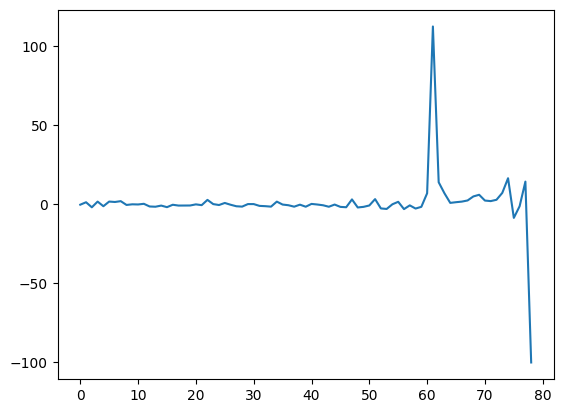

In [ ]:
plt.plot(best_rewards), np.median(best_rewards), np.max(best_rewards), np.min(best_rewards)

In [ ]:
res = {}
seeds = [0, 1, 5, 10, 21, 42, 47, 63, 84, 100, 121, 144]
for seed in seeds[:2]:
    actions = get_random_actions(env, seed)
    # best_actions = find_best_actions(env, actions)
    # print(f"[{seed}] Actions length improvement:",len(actions), "->", len(best_actions))
    # res[seed] = best_actions

In [ ]:
obs = get_obs(env, res)
array_obs = np.concatenate(obs[:])
array_obs.shape

ValueError: need at least one array to concatenate

In [ ]:
array_actions = np.concatenate([np.array(act[1]) for act in res.items()][:])

# Plot data

In [ ]:


color = array_actions
speed = array_obs[:, 3]
theta = array_obs[:, 2]
plt.figure(figsize=(7, 3), dpi=200)
plt.scatter(theta, speed, c=color, s=1), #print(obs[:, 2].shape)
plt.vlines([0.032, -0.032], ymin=min(speed), ymax=max(speed))
plt.hlines([0], xmin=min(theta), xmax=max(theta))
plt.xlabel(r'$\theta$')
plt.ylabel('omega')
plt.colorbar();

# Train LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lbc = LGBMClassifier(n_estimators=100)

lbc.fit(array_obs, array_actions)
accuracy_score(array_actions, lbc.predict(array_obs))

In [ ]:
lbc.feature_importances_

# Test model on environment
It suuucks, I saved *next_obs* and not the actual obs

In [ ]:
steps = []
for seed in range(1, 200, 5):
    env.seed(seed)
    ob = env.reset()

    step = 0
    while True:
        # print(ob.reshape(1, -1).shape)
        action = lbc.predict(ob.reshape(1, -1))[0]
        # action = res[seeds[4]][step]
        ob, reward, terminated, info = env.step(action)
        step+=1
        if terminated: steps.append(step);break
        
    print(seed, ':',step)

In [ ]:
np.median(steps), np.mean(steps), np.min(steps), np.max(steps)